In [54]:
from tqdm import trange
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
#from main.feature import get_all_features
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from pickle import load
from sklearn.metrics import mean_squared_error

In [55]:
# Limit GPU memory to 50%
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    # Assuming your GPU has 8GB memory, you set memory_limit to 4GB (50%).
    tf.config.experimental.set_virtual_device_configuration(
        physical_devices[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]  # 50% of 8GB GPU
    )

In [56]:
X_train = np.load("../Model_train_data/X_train.npy", allow_pickle=True)
y_train = np.load("../Model_train_data/y_train.npy", allow_pickle=True)
X_test = np.load("../Model_train_data/X_test.npy", allow_pickle=True)
y_test = np.load("../Model_train_data/y_test.npy", allow_pickle=True)
yc_train = np.load("../Model_train_data/yc_train.npy", allow_pickle=True)
yc_test = np.load("../Model_train_data/yc_test.npy", allow_pickle=True)

In [57]:
def make_generator_model(input_dim, output_dim, feature_size) -> tf.keras.models.Model:

    model = Sequential()  # Initialize the model
    model.add(GRU(units=1024, return_sequences=True, input_shape=(input_dim, feature_size),
                  recurrent_dropout=0.2))  # GRU layer with dropout 
    model.add(GRU(units=512, return_sequences=True, recurrent_dropout=0.2))  
    model.add(GRU(units=256, recurrent_dropout=0.2))  
    model.add(Dense(128))  # Dense layer with 128 units
    model.add(Dense(64))  
    model.add(Dense(units=output_dim))  # Output layer with output_dim units
    return model  

In [58]:
def make_discriminator_model():

    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Flatten())  # Convert feature maps to vector
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())  # Adds non-linearity without full ReLU saturation
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))  # Output: probability of being real
    return cnn_net

In [59]:
model = make_discriminator_model()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 2, 32)             128       
                                                                 
 conv1d_10 (Conv1D)          (None, 1, 64)             10304     
                                                                 
 conv1d_11 (Conv1D)          (None, 1, 128)            41088     
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 220)               28160     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 220)               0         
                                                                 
 dense_16 (Dense)            (None, 220)              

In [60]:
class GAN:
    def __init__(self, generator, discriminator, opt):
        self.opt = opt
        self.lr = opt["lr"]
        self.generator = generator
        self.discriminator = discriminator
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)  # Loss to distinguish real and fake
        self.generator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)  # Optimizer for generator
        self.discriminator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)  # Optimizer for discriminator

    def discriminator_loss(self, real_output, fake_output):
        # Calculates how well discriminator separates real vs fake data
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    def generator_loss(self, fake_output):
        # Encourages generator to fool the discriminator
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    @tf.function
    def train_step(self, real_x, real_y, yc):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_data = self.generator(real_x, training=True)  # Generate fake output
            generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
            d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)  # Combine fake with condition
            real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
            d_real_input = tf.concat([real_y_reshape, yc], axis=1)  # Combine real with condition

            real_output = self.discriminator(d_real_input, training=True)  # Discriminator on real
            fake_output = self.discriminator(d_fake_input, training=True)  # Discriminator on fake

            gen_loss = self.generator_loss(fake_output)  # Compute generator loss
            disc_loss = self.discriminator_loss(real_output, fake_output)  # Compute discriminator loss

        # Apply gradients for both generator and discriminator
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': gen_loss}

    def train(self, real_x, real_y, yc, opt):
        train_hist = {'D_losses': [], 'G_losses': [], 'per_epoch_times': []}  # Track training history
        epochs = opt["epoch"]
        total_start_time = time.time()  # Track total training time

        for epoch in range(epochs):
            start = time.time()
            real_price, fake_price, loss = self.train_step(real_x, real_y, yc)

            train_hist['D_losses'].append([loss['d_loss'].numpy()])
            train_hist['G_losses'].append([loss['g_loss'].numpy()])
            train_hist['per_epoch_times'].append(time.time() - start)

        tf.keras.models.save_model(self.generator, '../Model/GAN_model_final.h5')  # Save final generator

        total_training_time = time.time() - total_start_time
        print("Total training time: {:.2f} seconds".format(total_training_time))

        # Reshape for evaluation
        Predicted_price = np.array(fake_price.numpy()).reshape(fake_price.shape[0], fake_price.shape[1])
        Real_price = np.array(real_price.numpy()).reshape(real_price.shape[0], real_price.shape[1])

        # Plot and save loss curves
        plt.plot(train_hist['D_losses'], label='D_loss')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Generator and Discriminator Loss Over Epochs')
        plt.savefig('../Training_loss/GAN_loss_plot.png')
        plt.show()

        # Return output and normalized RMSE
        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

C:\Users\ASUS\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
C:\Users\ASUS\anaconda3\envs\gpu_env\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Total training time: 66.28 seconds


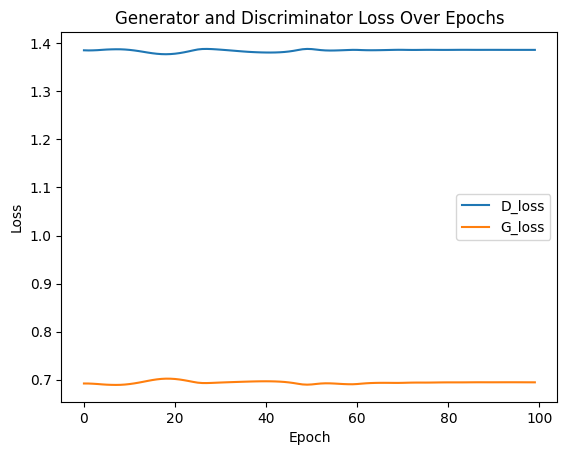

In [61]:
if __name__ == '__main__':
    input_dim = X_train.shape[1]  # Input time steps
    feature_size = X_train.shape[2]  # Number of features per time step
    output_dim = y_train.shape[1]  # Output dimension

    opt = {"lr": 0.00016, "epoch": 100, 'bs': 64}  # Set hyperparameters

    # Initialize and train GAN model
    generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
    discriminator = make_discriminator_model()
    gan = GAN(generator, discriminator, opt)
    Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, opt)

In [62]:
# Rescale back the real dataset
X_scaler = load(open('../Model_train_data/X_scaler.pkl', 'rb'))
y_scaler = load(open('../Model_train_data/y_scaler.pkl', 'rb'))
train_predict_index = np.load("../Model_train_data/index_train.npy", allow_pickle=True)
test_predict_index = np.load("../Model_train_data/index_test.npy", allow_pickle=True)

C:\Users\ASUS\anaconda3\envs\gpu_env\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [63]:
rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

In [64]:
predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5836\3428353848.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5836\3428353848.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


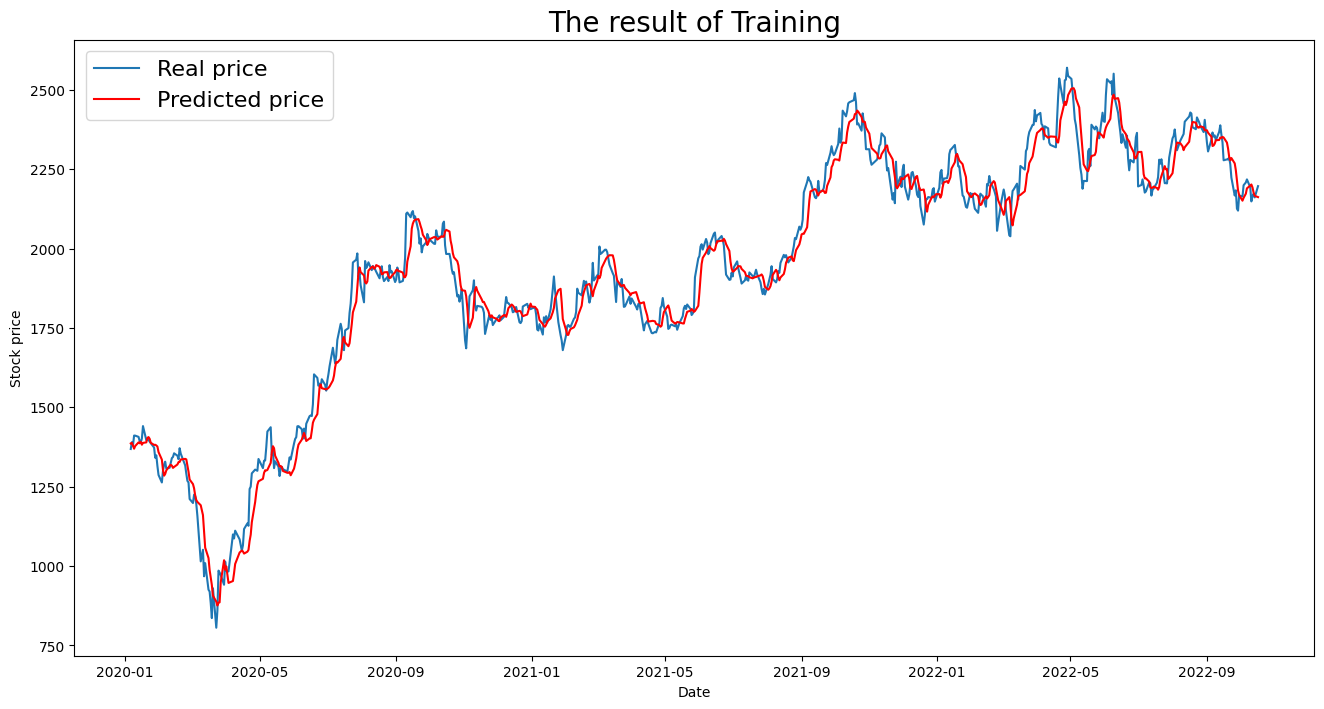

In [65]:
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)
    
    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color = 'r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.savefig('../Training_loss/GAN_training_Stock_plot.png')
    plt.show()

In [66]:
# Calculate RMSE
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('-- Train RMSE -- ', RMSE)

-- Train RMSE --  57.58987178754603


In [67]:
from tensorflow.keras.models import load_model
generator = load_model('../Model/GAN_model_final.h5')

In [68]:
fake_test_scaled = generator.predict(X_test, batch_size=64)

In [69]:
# 4. Inverse‑scale the GAN’s outputs and the true test values
fake_test = y_scaler.inverse_transform(
    fake_test_scaled.reshape(-1, 1)
).reshape(fake_test_scaled.shape)

In [70]:
real_test = y_scaler.inverse_transform(
    y_test.reshape(-1, 1)
).reshape(y_test.shape)

In [71]:
predict_result = pd.DataFrame()
for i in range(fake_test.shape[0]):
    y_predict = pd.DataFrame(fake_test[i], columns=["predicted_price"], index=test_predict_index[i:i+y_test.shape[1]])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
#
real_price = pd.DataFrame()
for i in range(real_test.shape[0]):
    y_train = pd.DataFrame(real_test[i], columns=["real_price"], index=test_predict_index[i:i+y_test.shape[1]])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5836\4138306018.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5836\4138306018.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


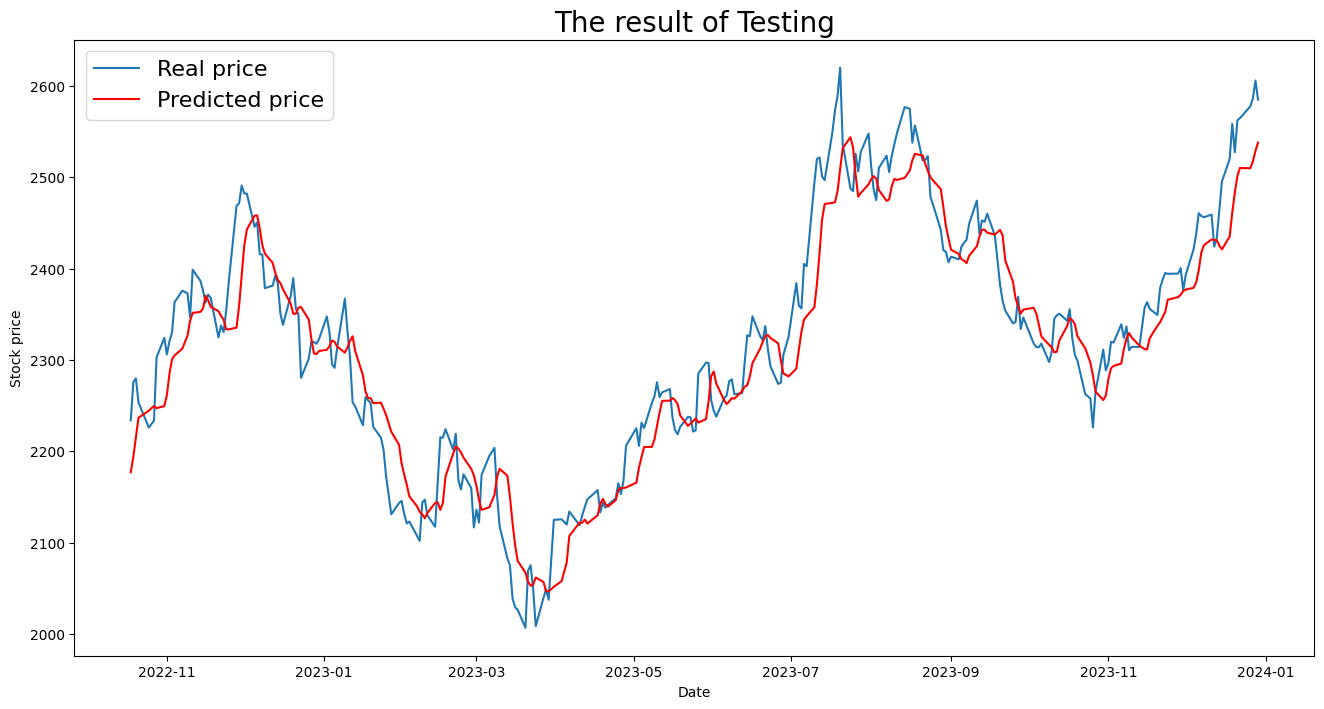

-- Test RMSE --  43.406896529473954


In [72]:
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)
    
    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color = 'r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing", fontsize=20)
    plt.savefig('../Training_loss/GAN_Testing_plot.png')
    plt.show()

# Calculate RMSE
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('-- Test RMSE -- ', RMSE)